In [95]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import statistics as st

In [96]:
monte_carlo_df = pd.read_csv('monte_carlo_10000.csv').drop(columns=['sample'])
training_df = pd.read_csv('training_data_bending.csv')

training_df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,26.396962,28.542961,2.50,2.15,1.63,75.95,127.83,263.44,66771.2
1,28.601368,30.559906,2.83,2.02,1.44,75.76,127.25,246.66,69501.7
2,28.026568,29.325711,2.85,1.78,1.44,76.51,127.53,243.62,65759.5
3,27.053592,28.547982,2.71,1.72,1.51,75.41,127.61,258.13,65259.4
4,27.549563,28.899586,2.67,1.74,1.65,76.22,128.53,261.38,65053.8


In [97]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[['max_force']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
monte_carlo_array = monte_carlo_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
monte_carlo_array_scaled = scaler.transform(monte_carlo_array)
X_test = scaler.transform(X_test)

<h1>SVR model

In [98]:
C = 778
epsilon = 0.0046
gamma = 0.01

In [99]:
SVR_model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon, verbose=False)
SVR_model.fit(X_train, Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=778, epsilon=0.0046, gamma=0.01)

In [100]:
Y_predicted_SVR = SVR_model.predict(X_test)
mape_SVR = mean_absolute_percentage_error(Y_test, Y_predicted_SVR)
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")

MAPE, for SVR: 0.27 %


In [101]:
predicted_values = SVR_model.predict(monte_carlo_array_scaled)
monte_carlo_df['predicted_mean_force'] = predicted_values
monte_carlo_df.head()

,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs,predicted_mean_force
0,2.76,1.96,1.67,75.29,127.80,278.56,73252.4,33.368911
1,2.84,2.29,1.39,75.81,127.68,277.41,65871.1,34.090792
2,2.63,2.21,1.53,75.94,128.37,289.44,65737.1,32.434289
3,2.52,1.85,1.52,75.57,127.39,285.63,63937.5,28.312934
4,2.78,1.97,1.52,75.45,128.33,282.14,71745.5,33.316992


<h1> Monte Carlo plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


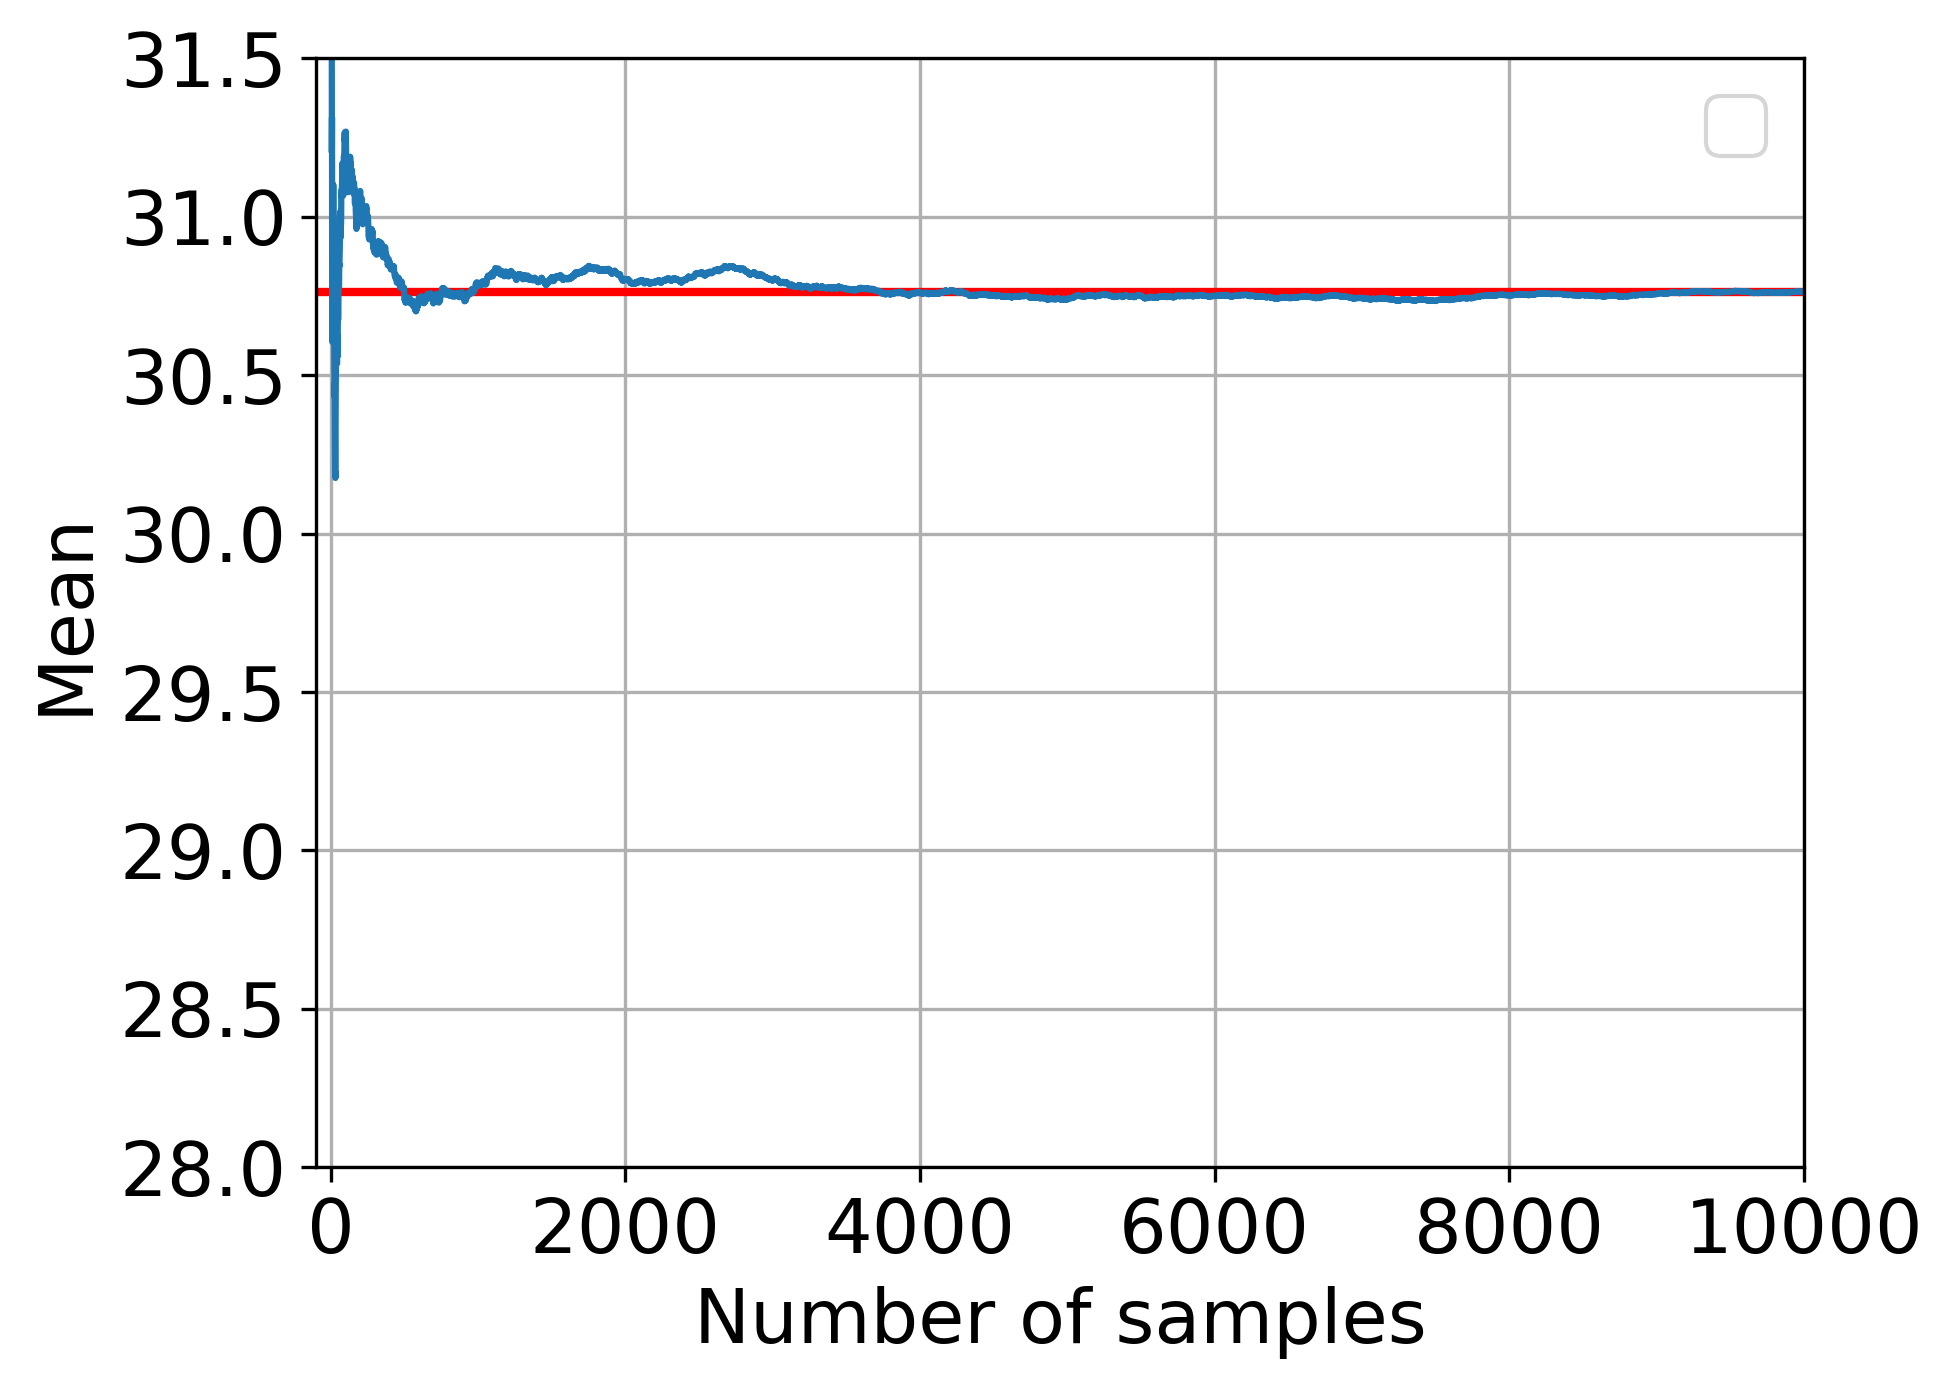

In [106]:
# Check convergence of mean
mean = np.zeros(len(monte_carlo_df))
for i in range(len(monte_carlo_df)):
    mean[i] = np.mean(monte_carlo_df['predicted_mean_force'][:i+1])
plt.figure(dpi=300)
plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999]), color='r', linewidth=2)
#plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999])*1.001, color='r', linewidth=1)
#plt.axhline(y=np.mean(monte_carlo_df['predicted_mean_force'][:9999])*0.999, color='r', linewidth=1)
plt.plot(mean)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Number of samples',fontsize =18)
plt.ylabel('Mean', fontsize =18)
plt.ylim(28, 31.5)
plt.xlim(-100, 10000)
plt.grid()
plt.show()



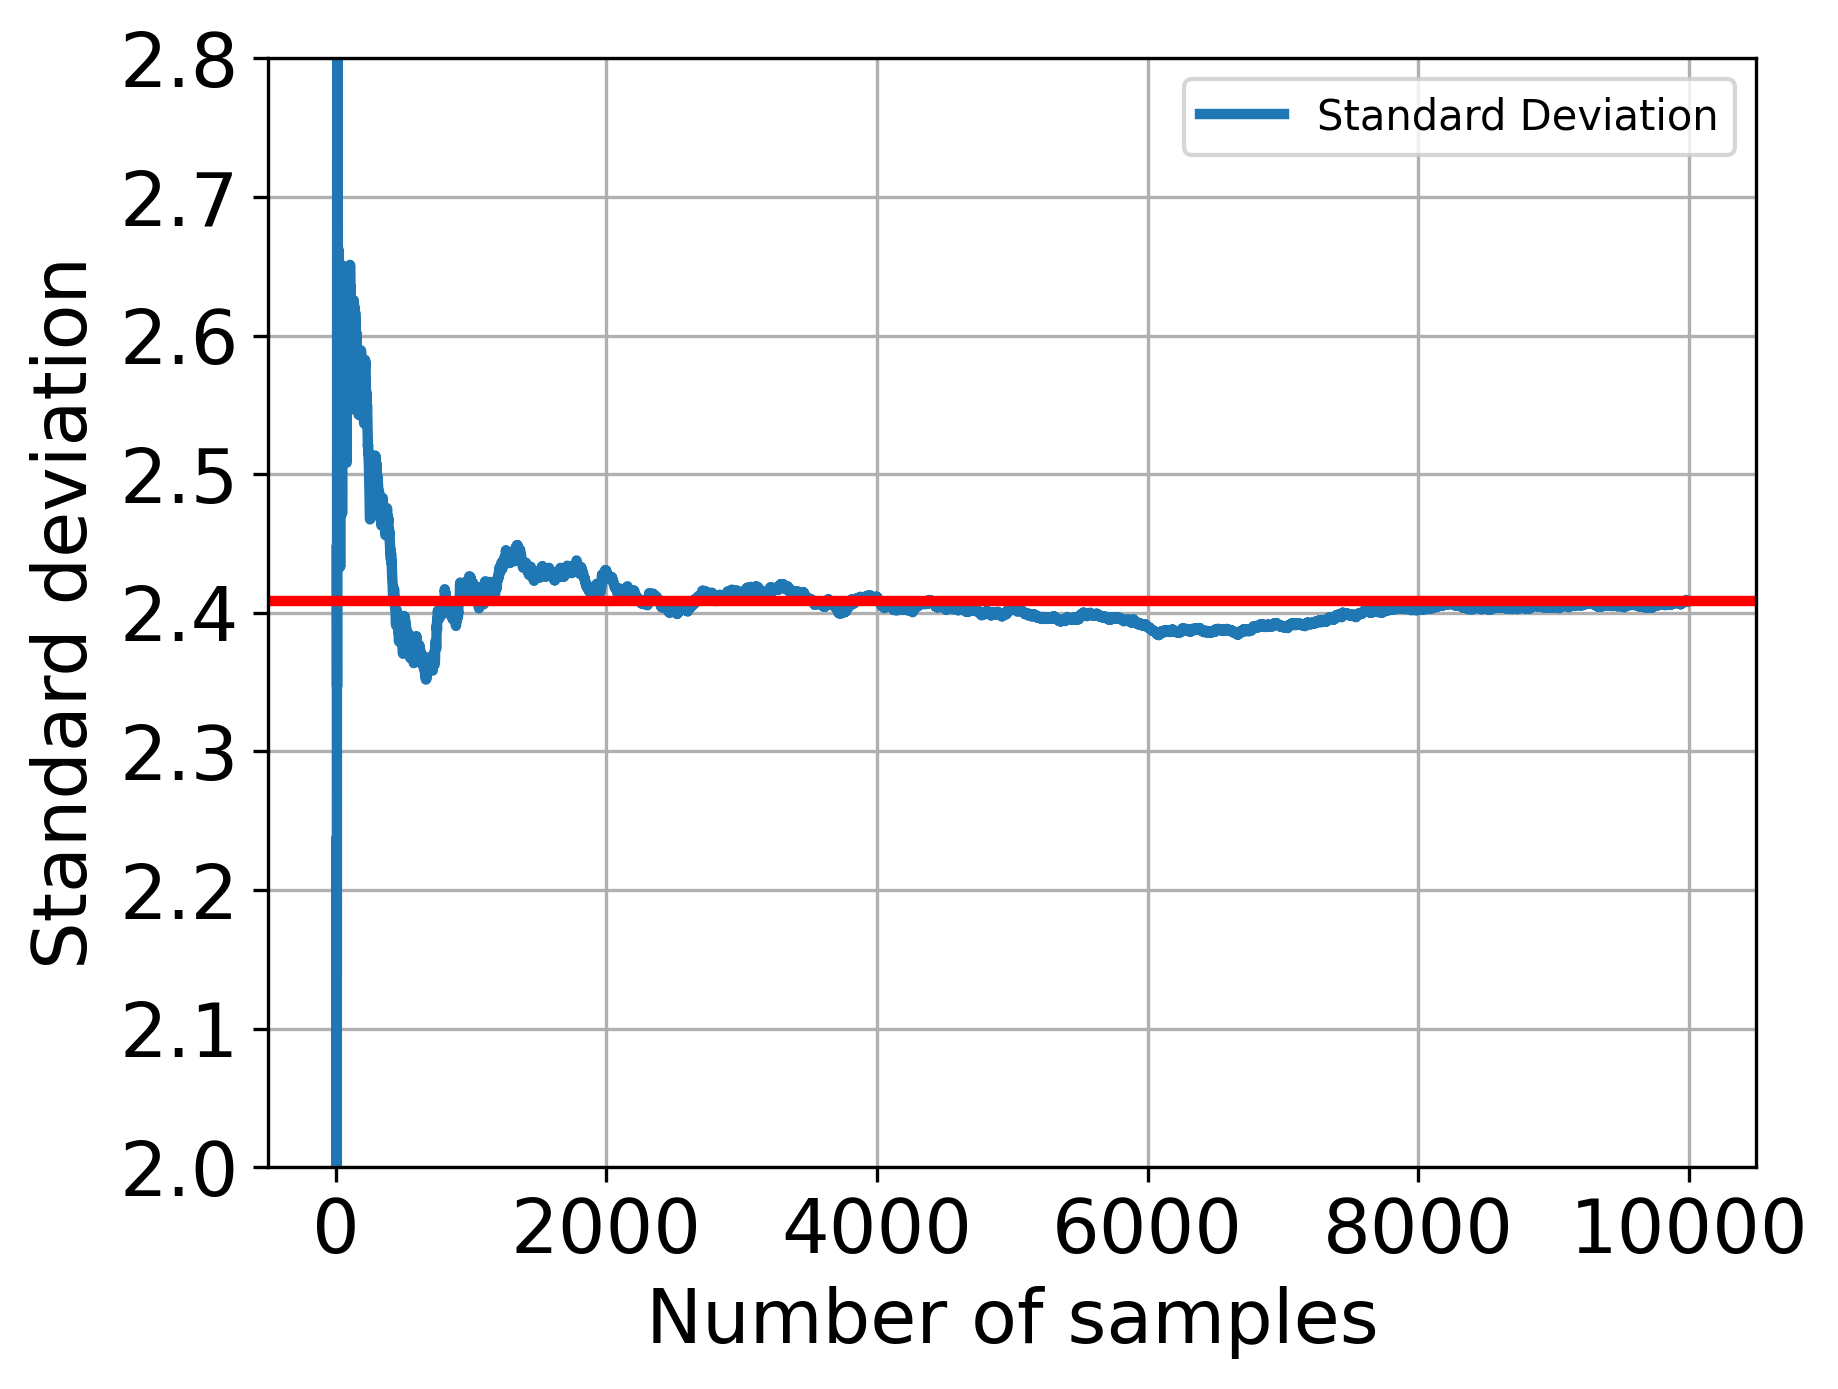

In [107]:
predicted_std = monte_carlo_df['predicted_mean_force']

# Calculate cumulative standard deviation
std = np.zeros(len(predicted_std))
for i in range(len(predicted_std)):
    std[i] = np.std(predicted_std[:i+1])

plt.figure(dpi=300)
plt.plot(std, label='Standard Deviation', linewidth=2.5)
plt.axhline(y=np.std(monte_carlo_df['predicted_mean_force'][:9999]), color='r', linewidth=2.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.ylim(2.0, 2.8)
plt.xlabel('Number of samples',fontsize=18)
plt.ylabel('Standard deviation', fontsize =18)
plt.grid()
plt.legend()
plt.show()

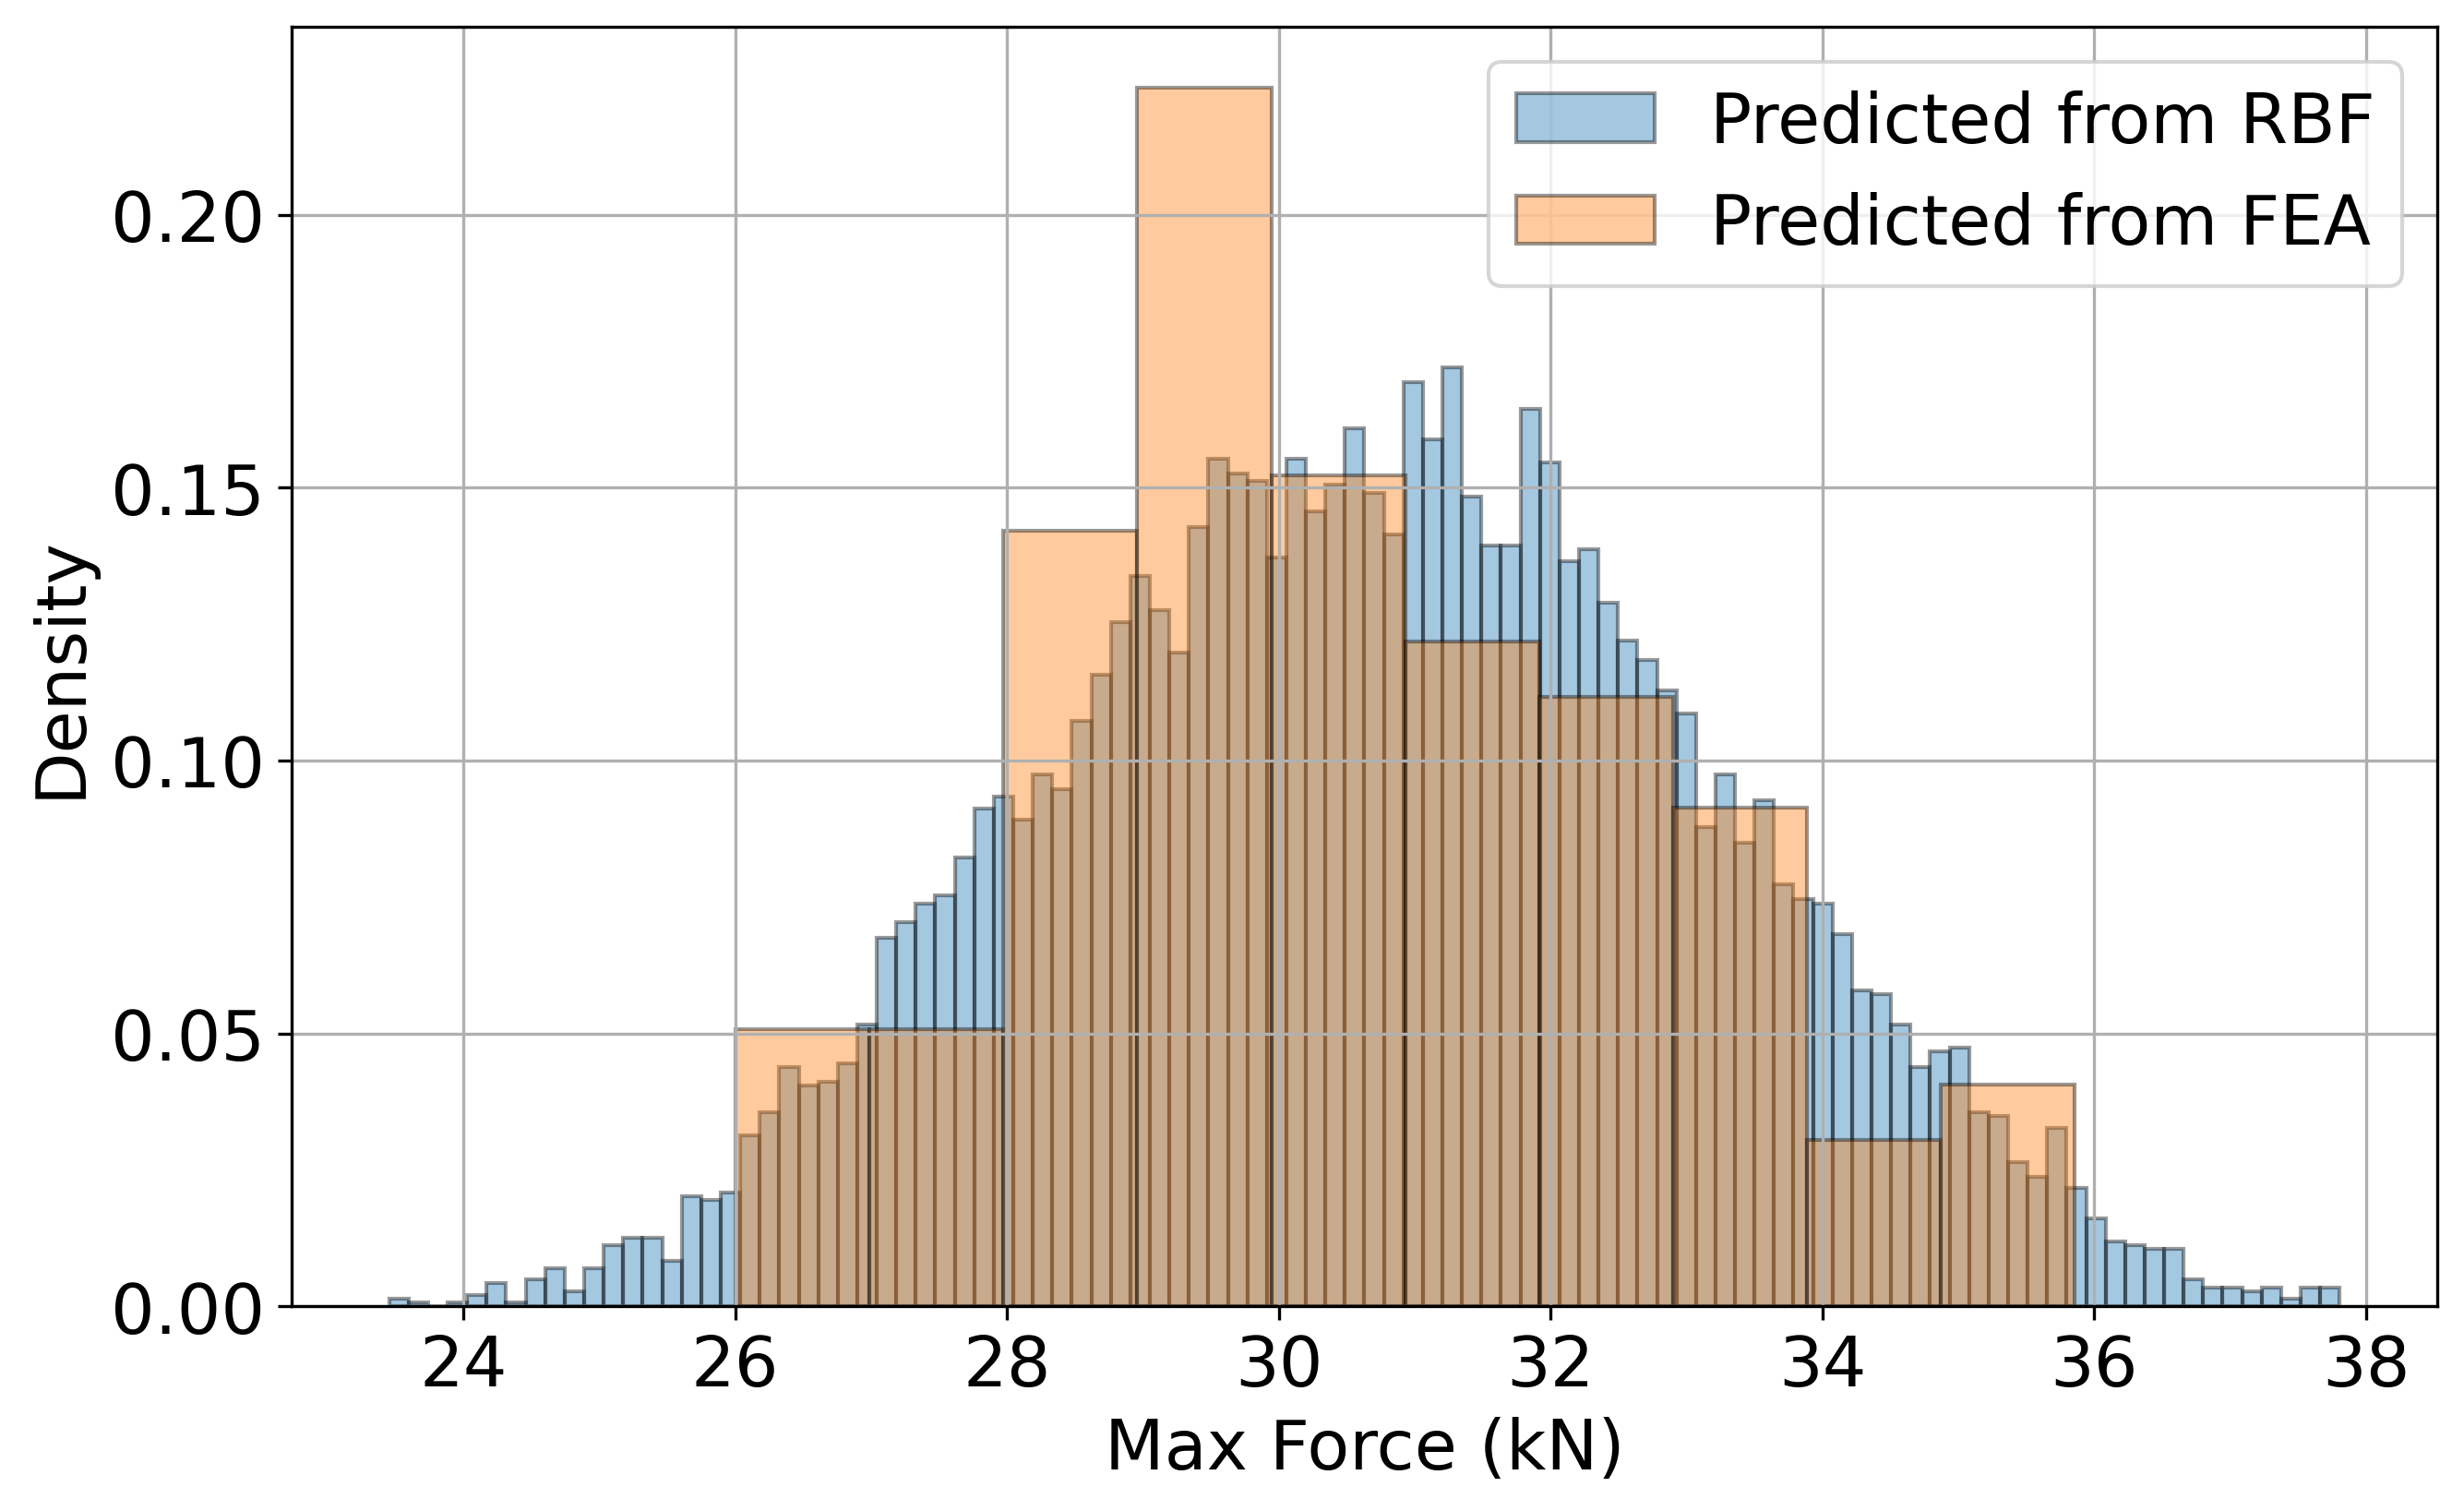

In [104]:
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(
    x=monte_carlo_df['predicted_mean_force'],
    bins=100,
    label='Predicted from SVR',
    alpha=0.4, 
    edgecolor='black',
    linewidth=1,
    density=True
    )

plt.hist(
    x=training_df['max_force'], 
    bins=10, 
    label='Predicted from FEA', 
    alpha=0.4, 
    edgecolor='black', 
    linewidth=1,
    density=True
    )

mean = st.mean(monte_carlo_df['predicted_mean_force'])
st_dev = st.stdev(monte_carlo_df['predicted_mean_force'])

#plt.axvline(mean, color ='k', linewidth = 2.5,linestyle = 'dashed', label = 'Mean value')
#plt.axvline(mean+st_dev, color ='y',linestyle = 'dashed',linewidth=2.5, label ='Std.deviation')
#plt.axvline(mean-st_dev, color ='y',linestyle = 'dashed',linewidth= 2.5)
plt.grid()
plt.xlabel('Max Force (kN)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


<h1>Changing amount of data

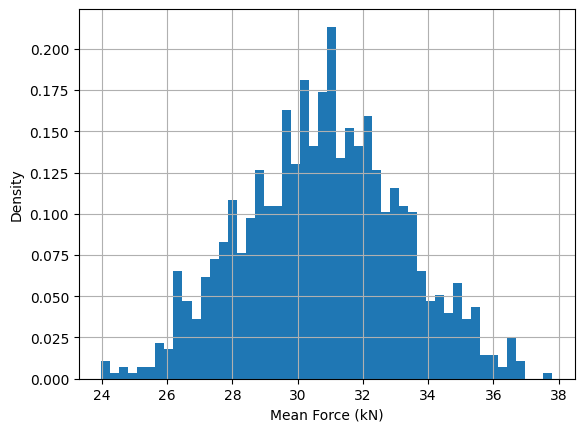

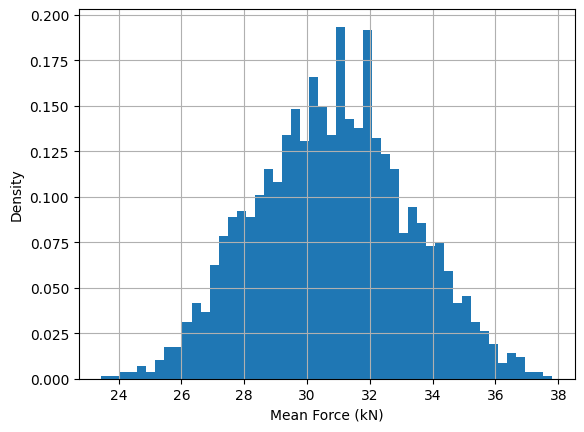

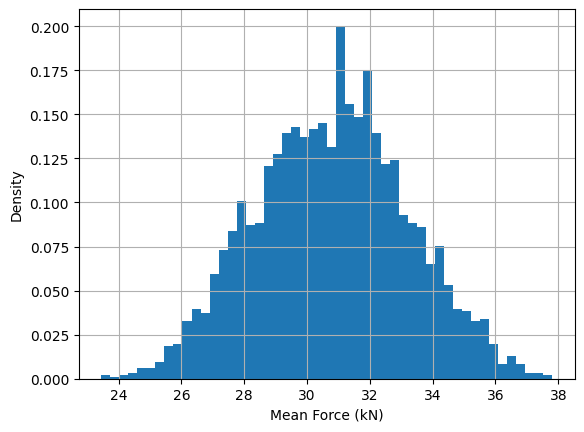

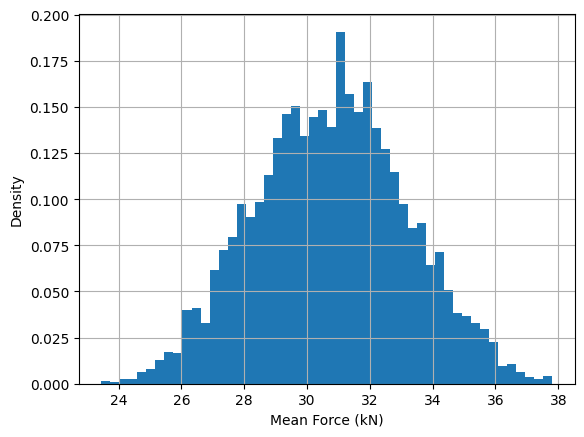

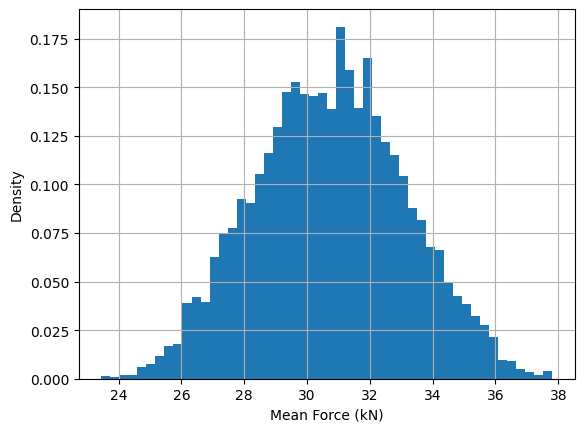

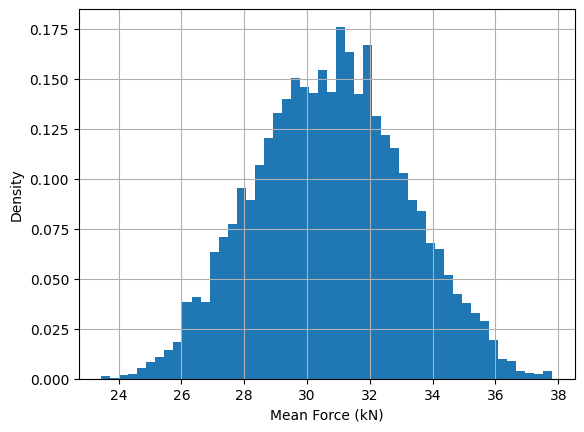

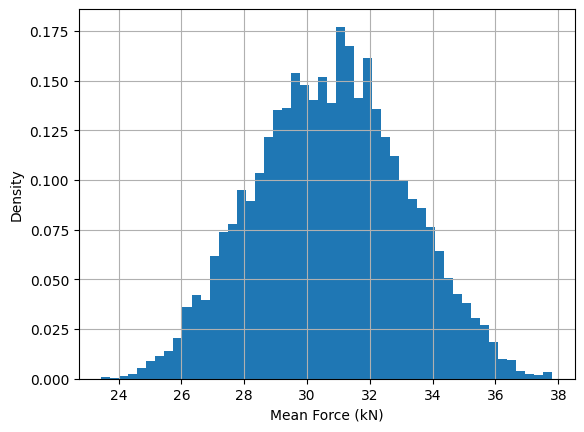

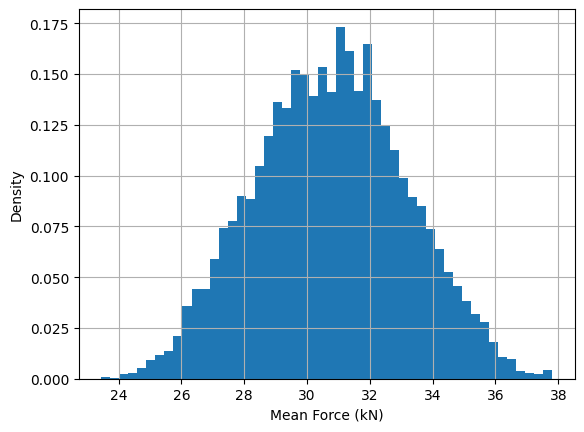

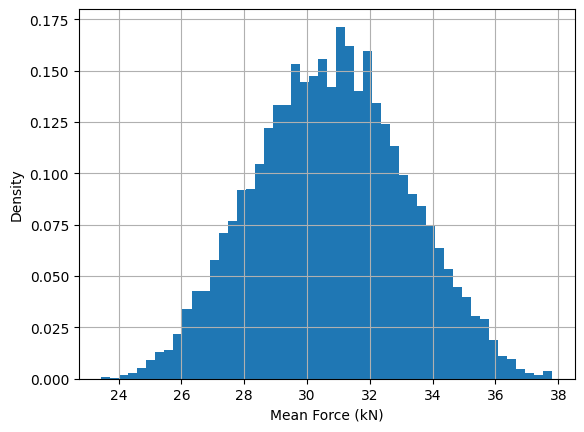

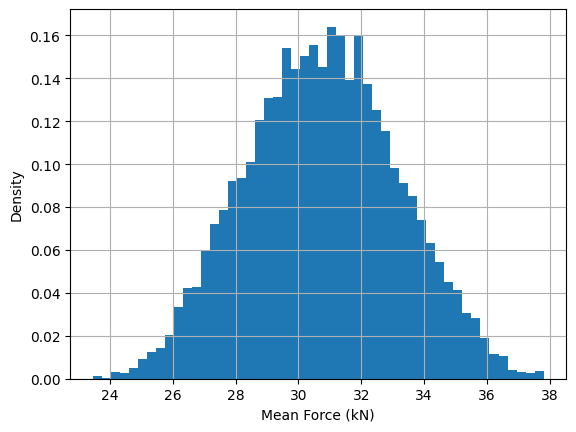

KeyboardInterrupt: 

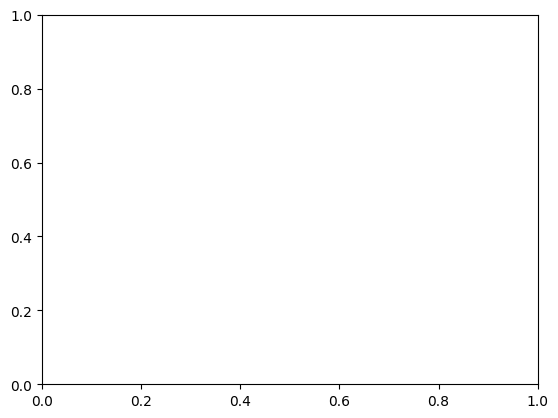

In [ ]:
for i in range(10):
    plt.hist(
        x=monte_carlo_df['predicted_mean_force'][:1000*(i+1)],
        bins=50,
        label='Predicted',
        density=True,
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()

<h1>Changing number of boxes

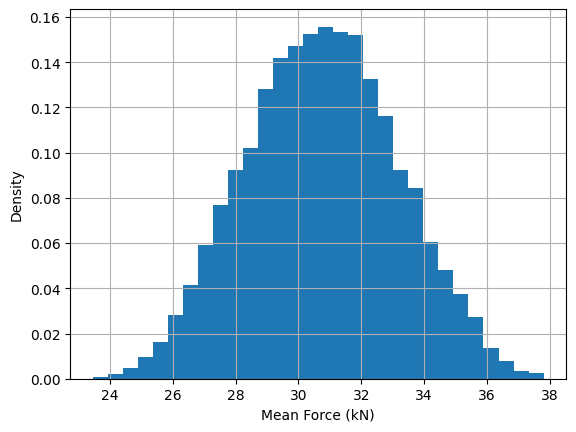

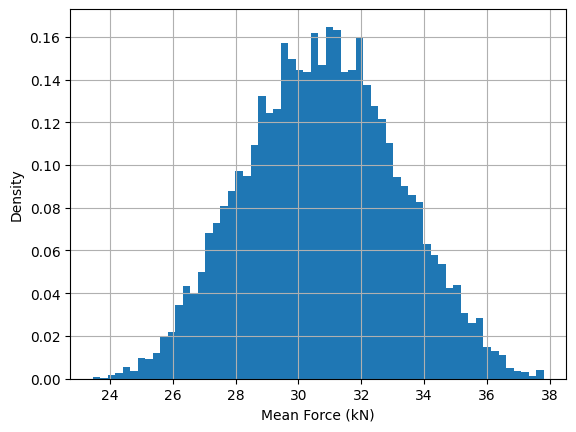

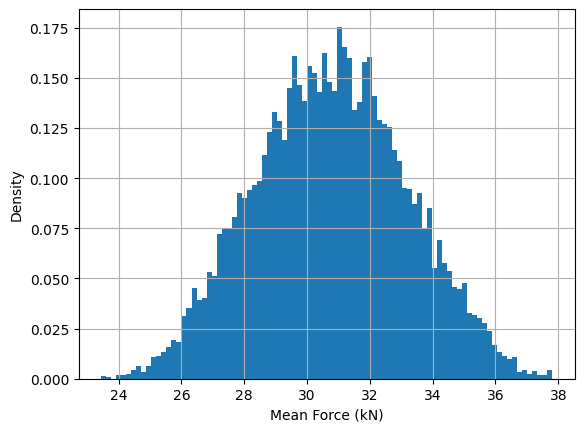

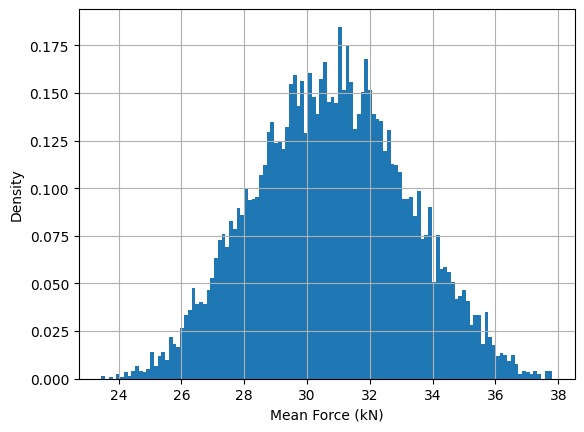

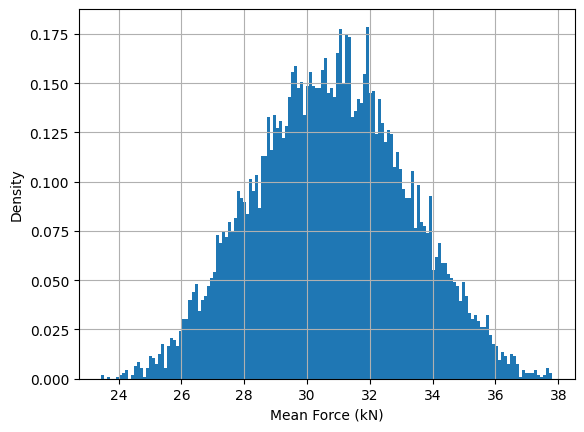

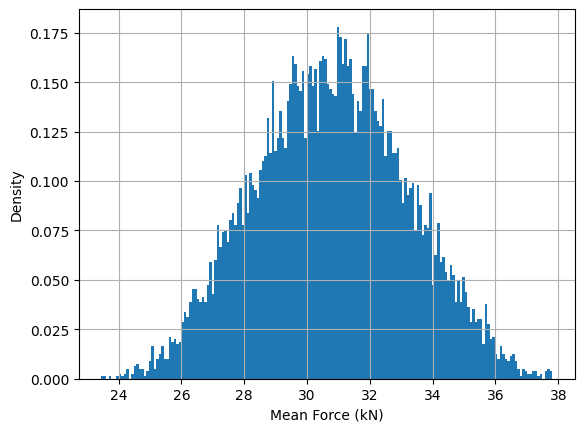

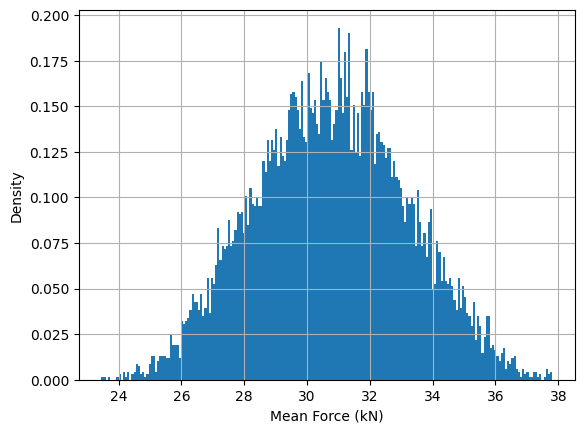

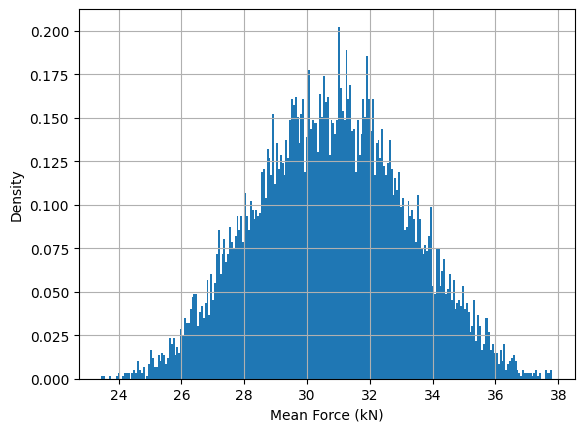

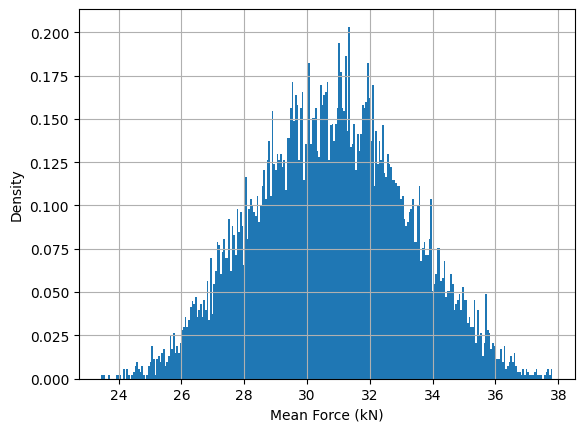

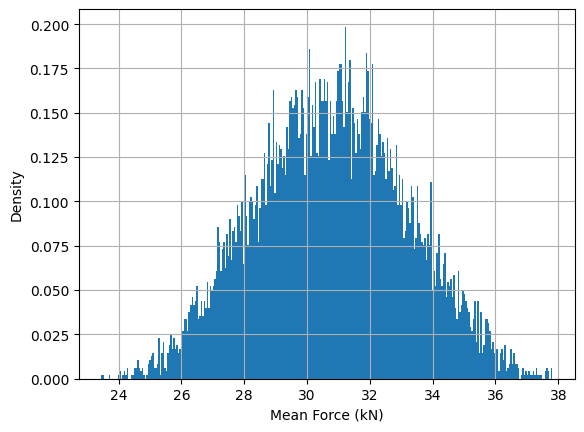

In [ ]:
for i in range(10):
    plt.hist(
        x=monte_carlo_df['predicted_mean_force'],
        bins=30*(i+1),
        label='Predicted',
        density=True
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()